<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Dayana Navarro Valencia y Juan Pablo Ruiz Magaña.

**Fecha:** 3 de Mayo 2021:

**Expediente** : 721470 y 721093
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link del Repositorio**https://github.com/JuanPablo2019/Tarea10.git

# Tarea 10:  Clase 23

# Tarea

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:
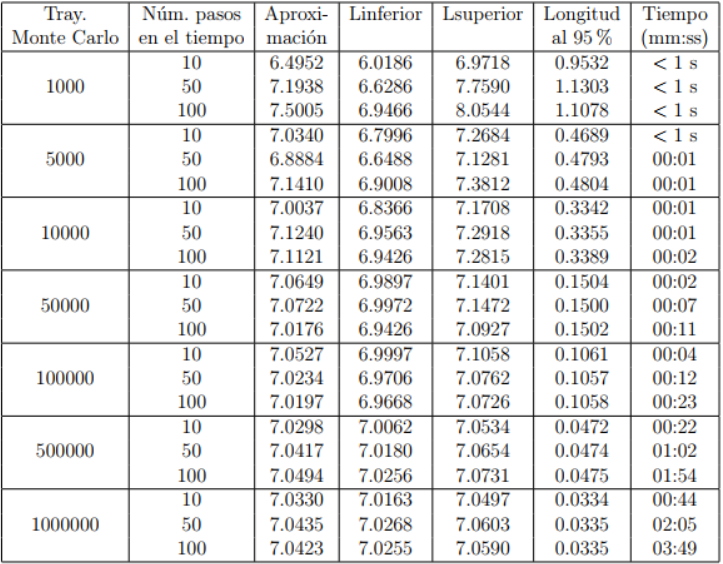

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

Se habilitará un enlace en canvas donde se adjuntará los resultados de dicha tarea

>**Nota:** Para generar índices de manera como se especifica en la tabla referirse a:
> - https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html
> - https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html
> - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html


### `Respuesta de Dayana`

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from time import time
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

# Riemann Call and Put

In [2]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

In [3]:
def Riemann_approach_call(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    # Resolvemos la ecuación de black scholes para obtener los precios
    t1 = time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(Average_t-strike,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t_1 = time()
    t_2 = t_1-t1
    return call.iloc[-1].Prima,i1[0],i1[1],i1[1]-i1[0],t_2

def Riemann_approach_put(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    # Resolvemos la ecuación de black scholes para obtener los precios
    t2 = time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    put = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(strike-Average_t,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put.sem().Prima
    mean_est = put.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t_1 = time()
    t_2 = t_1-t2
    return put.iloc[-1].Prima,i1[0],i1[1],i1[1]-i1[0],t_2

In [4]:
NbTraj = [1000,5000,10000,50000,100000,500000,1000000] 
NbStep = [10,50,100]

S0 = 100    
r = 0.10     
sigma = 0.2  
K = 100      
T = 1        

call_Riem = list(map(lambda N_1:list(map(lambda N1:Riemann_approach_call(K,r,S0,N1,N_1,sigma,T),NbStep)),NbTraj))

put_Riem = list(map(lambda N_2:list(map(lambda N2:Riemann_approach_put(K,r,S0,N2,N_2,sigma,T),NbStep)), NbTraj))

In [5]:
# Visualización de datos 
filas = ['Nbtray = %i' %i for i in NbTraj]
col = ['NbStep = %i' %i for i in NbStep]
df = pd.DataFrame(index=filas,columns=col)
df.loc[:,:] = call_Riem
df

NbStep = 10  \
Nbtray = 1000     (4.8795356412277435, 4.807541216242151, 4.9515...   
Nbtray = 5000     (5.37693349563244, 5.34232998700808, 5.4115370...   
Nbtray = 10000    (7.739976815229662, 7.701266248696715, 7.77868...   
Nbtray = 50000    (7.57469328968239, 7.5554046306864135, 7.59398...   
Nbtray = 100000   (13.194588092532465, 13.172254193006962, 13.21...   
Nbtray = 500000   (12.308813413890269, 12.299721610336904, 12.31...   
Nbtray = 1000000  (5.9653946039881, 5.962227032735009, 5.9685621...   

                                                        NbStep = 50  \
Nbtray = 1000     (6.070367483687486, 5.985902456022153, 6.15483...   
Nbtray = 5000     (5.986329036988322, 5.944798459480264, 6.02785...   
Nbtray = 10000    (8.24837517728919, 8.203763459835232, 8.292986...   
Nbtray = 50000    (6.699288827398494, 6.68391823192847, 6.714659...   
Nbtray = 100000   (6.725365943171779, 6.714338225734703, 6.73639...   
Nbtray = 500000   (5.577146261599853, 5.573037683971049, 5.58125...   
Nbtray = 1000000  (5.92125685589123, 5.918248241094116, 5.924265...   

                                                       NbStep = 100  
Nbtray = 1000     (8.622724754021029, 8.483602731797951, 8.76184...  
Nbtray = 5000     (8.368062914594434, 8.306520278198532, 8.42960...  
Nbtray = 10000    (6.993048421079727, 6.957936159017454, 7.02816...  
Nbtray = 50000    (8.053715765986253, 8.034672239937203, 8.07275...  
Nbtray = 100000   (5.428147349621643, 5.419366954254101, 5.43692...  
Nbtray = 500000   (8.106433374596191, 8.100583436142378, 8.11228...  
Nbtray = 1000000  (7.310636902958034, 7.30690215976942, 7.314371...

In [6]:
Aprox = [call_Riem[i][j][0] for i in range(7) for j in range(3)]
Linferior = [call_Riem[i][j][1] for i in range(7) for j in range(3)]
Lsuperior = [call_Riem[i][j][2] for i in range(7) for j in range(3)]
L95 = [call_Riem[i][j][3] for i in range(7) for j in range(3)]
Tiempo = [call_Riem[i][j][4] for i in range(7) for j in range(3)]

In [7]:
steps = [10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]
Trayectories = [1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,100000,
                100000,100000,500000,500000,500000,1000000,1000000,1000000]

Riem_call = pd.DataFrame({'Aproximacion':Aprox ,
                          'Linferior':Linferior,
                          'Lsuperior':Lsuperior,
                          'Longitud al 95%':L95,
                          'Tiempo mm:ss':Tiempo})

Riem_call['Tray. Monte Carlo'] = Trayectories 
Riem_call['Núm. pasos en el tiempo']=steps
Riem_call.set_index(['Tray. Monte Carlo','Núm. pasos en el tiempo'],inplace=True)
Riem_call.sort_index(inplace=True)

Riem_call

Aproximacion  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              4.880      4.808   
                  50                              6.070      5.986   
                  100                             8.623      8.484   
5000              10                              5.377      5.342   
                  50                              5.986      5.945   
...                                                 ...        ...   
500000            50                              5.577      5.573   
                  100                             8.106      8.101   
1000000           10                              5.965      5.962   
                  50                              5.921      5.918   
                  100                             7.311      7.307   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           4.952            0.144   
                  50                           6.155            0.169   
                  100                          8.762            0.278   
5000              10                           5.412            0.069   
                  50                           6.028            0.083   
...                                              ...              ...   
500000            50                           5.581            0.008   
                  100                          8.112            0.012   
1000000           10                           5.969            0.006   
                  50                           5.924            0.006   
                  100                          7.314            0.007   

                                           Tiempo mm:ss  
Tray. Monte Carlo Núm. pasos en el tiempo                
1000              10                              0.059  
                  50                              0.031  
                  100                             0.041  
5000              10                              0.011  
                  50                              0.043  
...                                                 ...  
500000            50                              3.194  
                  100                             8.642  
1000000           10                              0.988  
                  50                              7.957  
                  100                            20.789  

[21 rows x 5 columns]

In [8]:
# Visualización de datos 
filas = ['Nbtray = %i' %i for i in NbTraj]
col = ['NbStep = %i' %i for i in NbStep]
df = pd.DataFrame(index=filas,columns=col)
df.loc[:,:] = put_Riem 
df

NbStep = 10  \
Nbtray = 1000     (0.10234246205120484, 0.08668739517810302, 0.1...   
Nbtray = 5000     (2.2374913677626598, 2.225257509481493, 2.2497...   
Nbtray = 10000    (1.4808517798591203, 1.4721356997176476, 1.489...   
Nbtray = 50000    (0.8685660495085485, 0.8654090112753582, 0.871...   
Nbtray = 100000   (2.188059550344501, 2.1835643982709176, 2.1925...   
Nbtray = 500000   (0.5553076039695809, 0.5540945786524989, 0.556...   
Nbtray = 1000000  (0.907906805578388, 0.9074719661162147, 0.9083...   

                                                        NbStep = 50  \
Nbtray = 1000     (2.5261554190291164, 2.482949200421467, 2.5693...   
Nbtray = 5000     (2.3585428939617468, 2.342441426803746, 2.3746...   
Nbtray = 10000    (1.7811138211917492, 1.7758205732157923, 1.786...   
Nbtray = 50000    (2.088672794673497, 2.083937458540519, 2.09340...   
Nbtray = 100000   (2.994518824774794, 2.990767612535849, 2.99827...   
Nbtray = 500000   (3.4558539635307826, 3.453373458054604, 3.4583...   
Nbtray = 1000000  (1.7221378370285494, 1.7215213236914648, 1.722...   

                                                       NbStep = 100  
Nbtray = 1000     (2.521051303782003, 2.48566280504144, 2.556439...  
Nbtray = 5000     (2.401479971758878, 2.3875439675350254, 2.4154...  
Nbtray = 10000    (2.6812248515030603, 2.668748161614464, 2.6937...  
Nbtray = 50000    (1.4297686902790243, 1.4274788373704874, 1.432...  
Nbtray = 100000   (2.405643510571703, 2.4023974287145897, 2.4088...  
Nbtray = 500000   (1.664595112399915, 1.663904371983861, 1.66528...  
Nbtray = 1000000  (2.210583594353918, 2.209716916281067, 2.21145...

In [9]:
Aprox = [put_Riem[i][j][0] for i in range(7) for j in range(3)]
Linferior = [put_Riem[i][j][1] for i in range(7) for j in range(3)]
Lsuperior = [put_Riem[i][j][2] for i in range(7) for j in range(3)]
L95 = [put_Riem[i][j][3] for i in range(7) for j in range(3)]
Tiempo = [put_Riem[i][j][4] for i in range(7) for j in range(3)]

In [10]:
steps = [10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]
Trayectories = [1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,100000,
                100000,100000,500000,500000,500000,1000000,1000000,1000000]

Riem_put = pd.DataFrame({'Aproximacion':Aprox ,
                          'Linferior':Linferior,
                          'Lsuperior':Lsuperior,
                          'Longitud al 95%':L95,
                          'Tiempo mm:ss':Tiempo})

Riem_put['Tray. Monte Carlo'] = Trayectories 
Riem_put['Núm. pasos en el tiempo']=steps
Riem_put.set_index(['Tray. Monte Carlo','Núm. pasos en el tiempo'],inplace=True)
Riem_put.sort_index(inplace=True)

Riem_put

Aproximacion  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              0.102      0.087   
                  50                              2.526      2.483   
                  100                             2.521      2.486   
5000              10                              2.237      2.225   
                  50                              2.359      2.342   
...                                                 ...        ...   
500000            50                              3.456      3.453   
                  100                             1.665      1.664   
1000000           10                              0.908      0.907   
                  50                              1.722      1.722   
                  100                             2.211      2.210   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           0.118        3.131e-02   
                  50                           2.569        8.641e-02   
                  100                          2.556        7.078e-02   
5000              10                           2.250        2.447e-02   
                  50                           2.375        3.220e-02   
...                                              ...              ...   
500000            50                           3.458        4.961e-03   
                  100                          1.665        1.381e-03   
1000000           10                           0.908        8.697e-04   
                  50                           1.723        1.233e-03   
                  100                          2.211        1.733e-03   

                                           Tiempo mm:ss  
Tray. Monte Carlo Núm. pasos en el tiempo                
1000              10                              0.020  
                  50                              0.038  
                  100                             0.049  
5000              10                              0.015  
                  50                              0.062  
...                                                 ...  
500000            50                              2.955  
                  100                             6.374  
1000000           10                              0.999  
                  50                              5.842  
                  100                            17.542  

[21 rows x 5 columns]

# Trapecio Call and Put

In [11]:
def Trapecio_approach_call(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    # Resolvemos la ecuación de black scholes para obtener los precios
    t1 = time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    DeltaT = 1/NbStep
    # generar una muestra normal std
    normal = st.norm.rvs(loc=0,scale=1,size=NbStep)
    h = T/NbStep
    
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    #trapecio
    trap = 2 + (r*h) + (normal*sigma)
    prices2 = prices.multiply(trap,axis=0)
    
    # Obtenemos los precios promedios
    sum_t = prices2.expanding().sum()
    strike = K
    inc = (h/2*T)
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima':(np.exp(-r*T))*(np.fmax(inc*sum_t-strike,0).mean(axis=1))}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t_1 = time()
    t_2 = t_1-t1
    return call.iloc[-1].Prima,i1[0],i1[1],i1[1]-i1[0],t_2

def Trapecio_approach_put(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    
    t2 = time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    DeltaT = 1/NbStep
    # generar una muestra normal std
    normal = st.norm.rvs(loc=0,scale=1,size=NbStep)
    h = T/NbStep
    
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    #trapecio
    trap = 2 + (r*h) + (normal*sigma)
    prices2 = prices.multiply(trap,axis=0)
    
    # Obtenemos los precios promedios
    sum_t = prices2.expanding().sum()
    strike = K
    inc = (h/2*T)
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    put = pd.DataFrame({'Prima':(np.exp(-r*T))*(np.fmax(strike-inc*sum_t,0).mean(axis=1))}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put.sem().Prima
    mean_est = put.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t_1 = time()
    t_2 = t_1-t2
    return put.iloc[-1].Prima,i1[0],i1[1],i1[1]-i1[0],t_2

In [12]:
NbTraj = [1000,5000,10000,50000,100000,500000,1000000] 
NbStep = [10,50,100]

S0 = 100    
r = 0.10     
sigma = 0.2  
K = 100      
T = 1        

call_Trap = list(map(lambda N_1:list(map(lambda N1:Trapecio_approach_call(K,r,S0,N1,N_1,sigma,T),NbStep)),NbTraj))

put_Trap = list(map(lambda N_2:list(map(lambda N2:Trapecio_approach_put(K,r,S0,N2,N_2,sigma,T),NbStep)), NbTraj))

In [14]:
# Visualización de datos 
filas = ['Nbtray = %i' %i for i in NbTraj]
col = ['NbStep = %i' %i for i in NbStep]
df = pd.DataFrame(index=filas,columns=col)
df.loc[:,:] = call_Trap
df

NbStep = 10  \
Nbtray = 1000     (5.996849786815179, 5.937292151063528, 6.05640...   
Nbtray = 5000     (6.117017597650342, 6.088652194606331, 6.14538...   
Nbtray = 10000    (4.86620889259089, 4.848923571303344, 4.883494...   
Nbtray = 50000    (1.7519688894343481, 1.750183542736044, 1.7537...   
Nbtray = 100000   (6.949316247176374, 6.941783211161368, 6.95684...   
Nbtray = 500000   (5.858921301544083, 5.855924107965598, 5.86191...   
Nbtray = 1000000  (10.923163269977362, 10.918684609148615, 10.92...   

                                                        NbStep = 50  \
Nbtray = 1000     (7.384143315308529, 7.296731641258644, 7.47155...   
Nbtray = 5000     (9.653456363487754, 9.59921348292803, 9.707699...   
Nbtray = 10000    (9.165269416686732, 9.128118033449939, 9.20242...   
Nbtray = 50000    (7.155750139697297, 7.143675507401913, 7.16782...   
Nbtray = 100000   (8.93133244516607, 8.920522238522606, 8.942142...   
Nbtray = 500000   (8.394605952376198, 8.390068402642209, 8.39914...   
Nbtray = 1000000  (7.180445893625065, 7.177838861009483, 7.18305...   

                                                       NbStep = 100  
Nbtray = 1000     (7.037245722351654, 6.954918862619589, 7.11957...  
Nbtray = 5000     (7.913358908821674, 7.870354248894059, 7.95636...  
Nbtray = 10000    (7.131564808109822, 7.104762354401683, 7.15836...  
Nbtray = 50000    (7.638214762098525, 7.624904602246843, 7.65152...  
Nbtray = 100000   (8.55125493394064, 8.540469727327933, 8.562040...  
Nbtray = 500000   (5.636568749054877, 5.633720529641314, 5.63941...  
Nbtray = 1000000  (6.9800583206878155, 6.977484108129559, 6.9826...

In [15]:
Aprox = [call_Trap[i][j][0] for i in range(7) for j in range(3)]
Linferior = [call_Trap[i][j][1] for i in range(7) for j in range(3)]
Lsuperior = [call_Trap[i][j][2] for i in range(7) for j in range(3)]
L95 = [call_Trap[i][j][3] for i in range(7) for j in range(3)]
Tiempo = [call_Trap[i][j][4] for i in range(7) for j in range(3)]

In [16]:
steps = [10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]
Trayectories = [1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,100000,
                100000,100000,500000,500000,500000,1000000,1000000,1000000]

Trap_call = pd.DataFrame({'Aproximacion':Aprox ,
                          'Linferior':Linferior,
                          'Lsuperior':Lsuperior,
                          'Longitud al 95%':L95,
                          'Tiempo mm:ss':Tiempo})

Trap_call['Tray. Monte Carlo'] = Trayectories 
Trap_call['Núm. pasos en el tiempo']=steps
Trap_call.set_index(['Tray. Monte Carlo','Núm. pasos en el tiempo'],inplace=True)
Trap_call.sort_index(inplace=True)

Trap_call

Aproximacion  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              5.997      5.937   
                  50                              7.384      7.297   
                  100                             7.037      6.955   
5000              10                              6.117      6.089   
                  50                              9.653      9.599   
...                                                 ...        ...   
500000            50                              8.395      8.390   
                  100                             5.637      5.634   
1000000           10                             10.923     10.919   
                  50                              7.180      7.178   
                  100                             6.980      6.977   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           6.056            0.119   
                  50                           7.472            0.175   
                  100                          7.120            0.165   
5000              10                           6.145            0.057   
                  50                           9.708            0.108   
...                                              ...              ...   
500000            50                           8.399            0.009   
                  100                          5.639            0.006   
1000000           10                          10.928            0.009   
                  50                           7.183            0.005   
                  100                          6.983            0.005   

                                           Tiempo mm:ss  
Tray. Monte Carlo Núm. pasos en el tiempo                
1000              10                              0.022  
                  50                              0.051  
                  100                             0.069  
5000              10                              0.019  
                  50                              0.063  
...                                                 ...  
500000            50                              3.259  
                  100                             6.397  
1000000           10                              1.104  
                  50                              6.342  
                  100                            21.947  

[21 rows x 5 columns]

In [17]:
# Visualización de datos 
filas = ['Nbtray = %i' %i for i in NbTraj]
col = ['NbStep = %i' %i for i in NbStep]
df = pd.DataFrame(index=filas,columns=col)
df.loc[:,:] = put_Trap
df

NbStep = 10  \
Nbtray = 1000     (0.03926014527427031, -1.7020070750622978, 1.7...   
Nbtray = 5000     (3.642232753694583, 2.887463403539485, 4.39700...   
Nbtray = 10000    (4.490389898497183, 3.9712836943559804, 5.0094...   
Nbtray = 50000    (3.5408223584884873, 3.3047853605121964, 3.776...   
Nbtray = 100000   (3.9342935709714557, 3.775498929918432, 4.0930...   
Nbtray = 500000   (5.600111254950008, 5.529684386238368, 5.67053...   
Nbtray = 1000000  (3.5316607004911806, 3.480172203784578, 3.5831...   

                                                        NbStep = 50  \
Nbtray = 1000     (2.542374628775656, 0.904734179009506, 4.18001...   
Nbtray = 5000     (2.597390464548937, 1.8563404235104695, 3.3384...   
Nbtray = 10000    (1.6900689401438038, 1.1584418735869382, 2.221...   
Nbtray = 50000    (1.5088069122984802, 1.272989603626545, 1.7446...   
Nbtray = 100000   (2.3728815918101116, 2.2079804014711506, 2.537...   
Nbtray = 500000   (2.003897409046515, 1.9297571168847958, 2.0780...   
Nbtray = 1000000  (3.4595295141490596, 3.4083096261499817, 3.510...   

                                                       NbStep = 100  
Nbtray = 1000     (2.1363440358512853, 0.471648189876807, 3.8010...  
Nbtray = 5000     (1.8124990985644251, 1.0624541150293672, 2.562...  
Nbtray = 10000    (2.627687237719315, 2.110042644513645, 3.14533...  
Nbtray = 50000    (3.6054706294555046, 3.3758256176261616, 3.835...  
Nbtray = 100000   (2.3068535453389876, 2.1413479993927274, 2.472...  
Nbtray = 500000   (2.7615745618033163, 2.687639598942687, 2.8355...  
Nbtray = 1000000  (1.9095679346088608, 1.8565435206167145, 1.962...

In [18]:
Aprox = [put_Trap[i][j][0] for i in range(7) for j in range(3)]
Linferior = [put_Trap[i][j][1] for i in range(7) for j in range(3)]
Lsuperior = [put_Trap[i][j][2] for i in range(7) for j in range(3)]
L95 = [put_Trap[i][j][3] for i in range(7) for j in range(3)]
Tiempo = [put_Trap[i][j][4] for i in range(7) for j in range(3)]

In [19]:
steps = [10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]
Trayectories = [1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,100000,
                100000,100000,500000,500000,500000,1000000,1000000,1000000]

Trap_put = pd.DataFrame({'Aproximacion':Aprox ,
                          'Linferior':Linferior,
                          'Lsuperior':Lsuperior,
                          'Longitud al 95%':L95,
                          'Tiempo mm:ss':Tiempo})

Trap_put['Tray. Monte Carlo'] = Trayectories 
Trap_put['Núm. pasos en el tiempo']=steps
Trap_put.set_index(['Tray. Monte Carlo','Núm. pasos en el tiempo'],inplace=True)
Trap_put.sort_index(inplace=True)

Trap_put

Aproximacion  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              0.039     -1.702   
                  50                              2.542      0.905   
                  100                             2.136      0.472   
5000              10                              3.642      2.887   
                  50                              2.597      1.856   
...                                                 ...        ...   
500000            50                              2.004      1.930   
                  100                             2.762      2.688   
1000000           10                              3.532      3.480   
                  50                              3.460      3.408   
                  100                             1.910      1.857   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           1.781            3.483   
                  50                           4.180            3.275   
                  100                          3.801            3.329   
5000              10                           4.397            1.510   
                  50                           3.338            1.482   
...                                              ...              ...   
500000            50                           2.078            0.148   
                  100                          2.836            0.148   
1000000           10                           3.583            0.103   
                  50                           3.511            0.102   
                  100                          1.963            0.106   

                                           Tiempo mm:ss  
Tray. Monte Carlo Núm. pasos en el tiempo                
1000              10                              0.017  
                  50                              0.042  
                  100                             0.072  
5000              10                              0.015  
                  50                              0.063  
...                                                 ...  
500000            50                              3.092  
                  100                             6.457  
1000000           10                              1.094  
                  50                              6.202  
                  100                            21.807  

[21 rows x 5 columns]

# CONCLUSION

Sabemos que las sumas de Rienman y el método del trapecio sirve para calcular aproximadamente el valor de una integral,pero la diferencia más significativa es que el margen de error, en la Regla del Trapecio, es más pequeño que en la suma de Riemann, y aqui se comprueba ya que nos podemos dar cuenta que las aproximaciones del trapecio son más consistentes y acercadas al valor que buscamos, sin embargo son mucho más precisas cuando las particiones son mayores

### `Respuesta de Juan Pablo`

In [9]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
%matplotlib inline
import time
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

>Función de que utiliza la solución de B&S para simular precios.

In [10]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

>Creo una función para obtener un call Asiatico por el método del trapecio.

In [11]:
# Función donde se almacenan todos los resultados
def Trapecio_approach_call(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    t1 = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    DeltaT = 1/NbStep
    # generar una muestra normal std
    normal = st.norm.rvs(loc=0,scale=1,size=NbStep)
    h = T/NbStep
    
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    #trapecio
    trap = 2 + (r*h) + (normal*sigma)
    prices2 = prices.multiply(trap,axis=0)
    
    # Obtenemos los precios promedios
    sum_t = prices2.expanding().sum()
    strike = K
    inc = (h/2*T)
    
    
    #Definimos el dataframe de strikes
   
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima':(np.exp(-r*T))*(np.fmax(inc*sum_t-strike,0).mean(axis=1))}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t2 = time.time()
    t = t2 - t1
    return np.array([call.iloc[-1].Prima,i1[0],i1[1],i1[1]-i1[0],t])
    if flag==True:
             
             return call, intervalo
    else: 
    
      return call.iloc[-1].Prima

## `Solución para el call asiático`
**_Método del Trapecio_**

>Comienzo por definir mis variables

In [12]:
r= 0.10
sigma = 0.20
Nbtraj = 1000
Nbstep = 100
K = 100
S0 = 100
T = 1

>Itero sobre las trayectorias y los días a simular 

In [13]:
NbTraj = [1000,5000,10000,50000,100000,500000,1000000]
NbStep = [10,50,100]

In [14]:
cols = [ 'A','Li','Ls','95','T']
N=[[Trapecio_approach_call(K,r,S0,j,i,sigma,T) for i in NbStep] for j in NbTraj]
N

[[array([6.67274025, 5.37087937, 7.97460113, 2.60372176, 0.12300849]),
  array([8.14967414, 7.65383393, 8.64551436, 0.99168043, 0.04793668]),
  array([7.02439824, 6.75386292, 7.29493355, 0.54107063, 0.11406064])],
 [array([5.90925951, 4.75336154, 7.06515748, 2.31179594, 0.36421323]),
  array([6.6625605 , 6.28231915, 7.04280186, 0.7604827 , 0.37394762]),
  array([8.06716697, 7.74058187, 8.39375207, 0.65317021, 0.45623469])],
 [array([5.92084099, 4.76517316, 7.07650881, 2.31133565, 0.45974255]),
  array([7.88752884, 7.40822205, 8.36683563, 0.95861359, 0.74556851]),
  array([7.62722083, 7.32741387, 7.92702778, 0.5996139 , 0.61217427])],
 [array([6.99258149, 5.62111899, 8.364044  , 2.74292501, 1.89988947]),
  array([6.3041598 , 5.94249349, 6.6658261 , 0.72333261, 2.05914855]),
  array([6.70587522, 6.44455847, 6.96719196, 0.52263348, 2.52858758])],
 [array([5.41929715, 4.36287174, 6.47572257, 2.11285083, 3.72827053]),
  array([7.48851485, 7.04542556, 7.93160415, 0.88617859, 5.33363557]),
  

>Creo DataFrames para los vectores obtenidos al iterar.

In [15]:
N1 = pd.DataFrame(N[0],columns=cols)
N2 = pd.DataFrame(N[1],columns=cols)
N3 = pd.DataFrame(N[2],columns=cols)
N4 = pd.DataFrame(N[3],columns=cols)
N5 = pd.DataFrame(N[4],columns=cols)
N6 = pd.DataFrame(N[5],columns=cols)
N7 = pd.DataFrame(N[6],columns=cols)

> Uno los DataFrames en uno solo

In [16]:
f1=N1.append(N2).append(N3).append(N4).append(N5).append(N6).append(N7)
f1

A     Li     Ls     95       T
0   6.673  5.371  7.975  2.604   0.123
1   8.150  7.654  8.646  0.992   0.048
2   7.024  6.754  7.295  0.541   0.114
0   5.909  4.753  7.065  2.312   0.364
1   6.663  6.282  7.043  0.760   0.374
..    ...    ...    ...    ...     ...
1   6.585  6.195  6.976  0.781  19.809
2   5.710  5.488  5.932  0.444  23.511
0   4.911  3.955  5.868  1.913  37.499
1   7.121  6.703  7.538  0.836  42.593
2   8.439  8.093  8.785  0.692  47.114

[21 rows x 5 columns]

>Creo un Data Frame con multiindice y agrego los resultados obtenidos.

In [17]:
steps = [10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]
Trayectories = [1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,100000,
                100000,100000,500000,500000,500000,1000000,1000000,1000000]
results = pd.DataFrame(columns=['Tray. Monte Carlo','Núm. pasos en el tiempo', 
                                'Aproximación','Linferior','Lsuperior','Longitud al 95%','Tiempo'])
results['Tray. Monte Carlo'] = Trayectories 
results['Núm. pasos en el tiempo']=steps
results.set_index(['Tray. Monte Carlo','Núm. pasos en el tiempo'],inplace=True)
results.sort_index(inplace=True)
results['Aproximación']=f1['A'].values
results['Linferior']=f1['Li'].values
results['Lsuperior']=f1['Ls'].values
results['Longitud al 95%']=f1['95'].values
results['Tiempo']=f1['T'].values

results

Aproximación  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              6.673      5.371   
                  50                              8.150      7.654   
                  100                             7.024      6.754   
5000              10                              5.909      4.753   
                  50                              6.663      6.282   
...                                                 ...        ...   
500000            50                              6.585      6.195   
                  100                             5.710      5.488   
1000000           10                              4.911      3.955   
                  50                              7.121      6.703   
                  100                             8.439      8.093   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           7.975            2.604   
                  50                           8.646            0.992   
                  100                          7.295            0.541   
5000              10                           7.065            2.312   
                  50                           7.043            0.760   
...                                              ...              ...   
500000            50                           6.976            0.781   
                  100                          5.932            0.444   
1000000           10                           5.868            1.913   
                  50                           7.538            0.836   
                  100                          8.785            0.692   

                                           Tiempo  
Tray. Monte Carlo Núm. pasos en el tiempo          
1000              10                        0.123  
                  50                        0.048  
                  100                       0.114  
5000              10                        0.364  
                  50                        0.374  
...                                           ...  
500000            50                       19.809  
                  100                      23.511  
1000000           10                       37.499  
                  50                       42.593  
                  100                      47.114  

[21 rows x 5 columns]

>Para una visualización más completa imprimo los resultados de 1 al 10 y del 11 al 21 por separado como se observa a continaución:

In [18]:
results.head(10)

Aproximación  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              6.673      5.371   
                  50                              8.150      7.654   
                  100                             7.024      6.754   
5000              10                              5.909      4.753   
                  50                              6.663      6.282   
                  100                             8.067      7.741   
10000             10                              5.921      4.765   
                  50                              7.888      7.408   
                  100                             7.627      7.327   
50000             10                              6.993      5.621   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           7.975            2.604   
                  50                           8.646            0.992   
                  100                          7.295            0.541   
5000              10                           7.065            2.312   
                  50                           7.043            0.760   
                  100                          8.394            0.653   
10000             10                           7.077            2.311   
                  50                           8.367            0.959   
                  100                          7.927            0.600   
50000             10                           8.364            2.743   

                                           Tiempo  
Tray. Monte Carlo Núm. pasos en el tiempo          
1000              10                        0.123  
                  50                        0.048  
                  100                       0.114  
5000              10                        0.364  
                  50                        0.374  
                  100                       0.456  
10000             10                        0.460  
                  50                        0.746  
                  100                       0.612  
50000             10                        1.900

In [19]:
results.tail(11)

Aproximación  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
50000             50                              6.304      5.942   
                  100                             6.706      6.445   
100000            10                              5.419      4.363   
                  50                              7.489      7.045   
                  100                             7.148      6.869   
...                                                 ...        ...   
500000            50                              6.585      6.195   
                  100                             5.710      5.488   
1000000           10                              4.911      3.955   
                  50                              7.121      6.703   
                  100                             8.439      8.093   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
50000             50                           6.666            0.723   
                  100                          6.967            0.523   
100000            10                           6.476            2.113   
                  50                           7.932            0.886   
                  100                          7.427            0.558   
...                                              ...              ...   
500000            50                           6.976            0.781   
                  100                          5.932            0.444   
1000000           10                           5.868            1.913   
                  50                           7.538            0.836   
                  100                          8.785            0.692   

                                           Tiempo  
Tray. Monte Carlo Núm. pasos en el tiempo          
50000             50                        2.059  
                  100                       2.529  
100000            10                        3.728  
                  50                        5.334  
                  100                       5.123  
...                                           ...  
500000            50                       19.809  
                  100                      23.511  
1000000           10                       37.499  
                  50                       42.593  
                  100                      47.114  

[11 rows x 5 columns]

## `Solución para el call asiático por el método`
**_Método de Riemann_**

1. Definio función que contenga el método de riemman para un call asiático.

In [20]:
# Función donde se almacenan todos los resultados
def Riemann_approach_call(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    t1 = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima': np.exp(-r*T) \
                 *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t2 = time.time()
    t = t2-t1
    return np.array([call.iloc[-1].Prima,i1[0],i1[1],i1[1]-i1[0],t])
    if flag==True:
         
        return call, intervalo
    else: 
        return call.iloc[-1].Prima

In [21]:
cols = [ 'A','Li','Ls','95','T']
N=[[Riemann_approach_call(K,r,S0,j,i,sigma,T) for i in NbStep] for j in NbTraj]
N

[[array([6.4118293 , 5.12906664, 7.69459197, 2.56552533, 0.09619212]),
  array([6.38634521, 5.9140555 , 6.85863492, 0.94457942, 0.06252384]),
  array([7.10659375, 6.73192192, 7.48126559, 0.74934367, 0.10772729])],
 [array([6.45007472, 5.17306585, 7.7270836 , 2.55401775, 0.29293799]),
  array([6.95025643, 6.42823672, 7.47227614, 1.04403942, 0.35243201]),
  array([7.31136412, 6.93434342, 7.68838483, 0.75404141, 0.26235437])],
 [array([6.40895358, 5.1383751 , 7.67953206, 2.54115696, 0.6241765 ]),
  array([6.94199574, 6.42143273, 7.46255875, 1.04112602, 0.46841526]),
  array([7.05700866, 6.69394215, 7.42007518, 0.72613302, 0.66590428])],
 [array([6.42399412, 5.1504087 , 7.69757955, 2.54717085, 1.94795036]),
  array([6.91894745, 6.40215027, 7.43574463, 1.03359436, 2.96527243]),
  array([7.07264412, 6.70821631, 7.43707193, 0.72885561, 3.02287674])],
 [array([6.42364282, 5.15083866, 7.69644697, 2.54560831, 4.26039314]),
  array([6.89060913, 6.37622465, 7.40499361, 1.02876895, 4.50634146]),
  

>Creo DataFrames para los vectores obtenidos al iterar.

In [22]:
N1 = pd.DataFrame(N[0],columns=cols)
N2 = pd.DataFrame(N[1],columns=cols)
N3 = pd.DataFrame(N[2],columns=cols)
N4 = pd.DataFrame(N[3],columns=cols)
N5 = pd.DataFrame(N[4],columns=cols)
N6 = pd.DataFrame(N[5],columns=cols)
N7 = pd.DataFrame(N[6],columns=cols)

> Uno los DataFrames en uno solo

In [23]:
f1=N1.append(N2).append(N3).append(N4).append(N5).append(N6).append(N7)
f1

A     Li     Ls     95       T
0   6.412  5.129  7.695  2.566   0.096
1   6.386  5.914  6.859  0.945   0.063
2   7.107  6.732  7.481  0.749   0.108
0   6.450  5.173  7.727  2.554   0.293
1   6.950  6.428  7.472  1.044   0.352
..    ...    ...    ...    ...     ...
1   6.915  6.399  7.431  1.032  22.652
2   6.970  6.611  7.329  0.718  24.621
0   6.441  5.164  7.717  2.554  46.218
1   6.921  6.405  7.438  1.033  48.439
2   6.976  6.616  7.335  0.719  46.525

[21 rows x 5 columns]

>Creo un Data Frame con multiindice y agrego los resultados obtenidos.

In [24]:
steps = [10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]
Trayectories = [1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,100000,
                100000,100000,500000,500000,500000,1000000,1000000,1000000]
results = pd.DataFrame(columns=['Tray. Monte Carlo','Núm. pasos en el tiempo', 
                                'Aproximación','Linferior','Lsuperior','Longitud al 95%','Tiempo'])
results['Tray. Monte Carlo'] = Trayectories 
results['Núm. pasos en el tiempo']=steps
results.set_index(['Tray. Monte Carlo','Núm. pasos en el tiempo'],inplace=True)
results.sort_index(inplace=True)
results['Aproximación']=f1['A'].values
results['Linferior']=f1['Li'].values
results['Lsuperior']=f1['Ls'].values
results['Longitud al 95%']=f1['95'].values
results['Tiempo']=f1['T'].values

results

Aproximación  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              6.412      5.129   
                  50                              6.386      5.914   
                  100                             7.107      6.732   
5000              10                              6.450      5.173   
                  50                              6.950      6.428   
...                                                 ...        ...   
500000            50                              6.915      6.399   
                  100                             6.970      6.611   
1000000           10                              6.441      5.164   
                  50                              6.921      6.405   
                  100                             6.976      6.616   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           7.695            2.566   
                  50                           6.859            0.945   
                  100                          7.481            0.749   
5000              10                           7.727            2.554   
                  50                           7.472            1.044   
...                                              ...              ...   
500000            50                           7.431            1.032   
                  100                          7.329            0.718   
1000000           10                           7.717            2.554   
                  50                           7.438            1.033   
                  100                          7.335            0.719   

                                           Tiempo  
Tray. Monte Carlo Núm. pasos en el tiempo          
1000              10                        0.096  
                  50                        0.063  
                  100                       0.108  
5000              10                        0.293  
                  50                        0.352  
...                                           ...  
500000            50                       22.652  
                  100                      24.621  
1000000           10                       46.218  
                  50                       48.439  
                  100                      46.525  

[21 rows x 5 columns]

>Para una visualización más completa imprimo los resultados de 1 al 10 y del 11 al 21 por separado como se observa a continaución:

In [25]:
results.head(10)

Aproximación  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              6.412      5.129   
                  50                              6.386      5.914   
                  100                             7.107      6.732   
5000              10                              6.450      5.173   
                  50                              6.950      6.428   
                  100                             7.311      6.934   
10000             10                              6.409      5.138   
                  50                              6.942      6.421   
                  100                             7.057      6.694   
50000             10                              6.424      5.150   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           7.695            2.566   
                  50                           6.859            0.945   
                  100                          7.481            0.749   
5000              10                           7.727            2.554   
                  50                           7.472            1.044   
                  100                          7.688            0.754   
10000             10                           7.680            2.541   
                  50                           7.463            1.041   
                  100                          7.420            0.726   
50000             10                           7.698            2.547   

                                           Tiempo  
Tray. Monte Carlo Núm. pasos en el tiempo          
1000              10                        0.096  
                  50                        0.063  
                  100                       0.108  
5000              10                        0.293  
                  50                        0.352  
                  100                       0.262  
10000             10                        0.624  
                  50                        0.468  
                  100                       0.666  
50000             10                        1.948

In [26]:
results.tail(11)

Aproximación  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
50000             50                              6.919      6.402   
                  100                             7.073      6.708   
100000            10                              6.424      5.151   
                  50                              6.891      6.376   
                  100                             6.945      6.588   
...                                                 ...        ...   
500000            50                              6.915      6.399   
                  100                             6.970      6.611   
1000000           10                              6.441      5.164   
                  50                              6.921      6.405   
                  100                             6.976      6.616   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
50000             50                           7.436            1.034   
                  100                          7.437            0.729   
100000            10                           7.696            2.546   
                  50                           7.405            1.029   
                  100                          7.302            0.715   
...                                              ...              ...   
500000            50                           7.431            1.032   
                  100                          7.329            0.718   
1000000           10                           7.717            2.554   
                  50                           7.438            1.033   
                  100                          7.335            0.719   

                                           Tiempo  
Tray. Monte Carlo Núm. pasos en el tiempo          
50000             50                        2.965  
                  100                       3.023  
100000            10                        4.260  
                  50                        4.506  
                  100                       4.909  
...                                           ...  
500000            50                       22.652  
                  100                      24.621  
1000000           10                       46.218  
                  50                       48.439  
                  100                      46.525  

[11 rows x 5 columns]

## `Solución para el put asiático por el método`
**_Método del Trapecio_**|

In [27]:
# Función donde se almacenan todos los resultados
def Trapecio_approach_put(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    t1 = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    DeltaT = 1/NbStep
    # generar una muestra normal std
    normal = st.norm.rvs(loc=0,scale=1,size=NbStep)
    h = T/NbStep
    
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    #trapecio
    trap = 2 + (r*h) + (normal*sigma)
    prices2 = prices.multiply(trap,axis=0)
    
    # Obtenemos los precios promedios
    sum_t = prices2.expanding().sum()
    strike = K
    inc = (h/2*T)
    
    
    #Definimos el dataframe de strikes
   
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    put = pd.DataFrame({'Prima':(np.exp(-r*T))*(np.fmax(strike-inc*sum_t,0).mean(axis=1))}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put.sem().Prima
    mean_est = put.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t2 = time.time()
    t = t2 - t1
    return np.array([put.iloc[-1].Prima,i1[0],i1[1],i1[1]-i1[0],t])
    if flag==True:
             
             return put, intervalo
    else: 
    
      return put.iloc[-1].Prima

>Itero sobre las trayectorias y los días a simular  

In [28]:
cols = [ 'A','Li','Ls','95','T']
N=[[Trapecio_approach_put(K,r,S0,j,i,sigma,T) for i in NbStep] for j in NbTraj]
N

[[array([  3.54892656, -12.91533959,  20.01319271,  32.9285323 ,
           0.08030367]),
  array([ 2.80679419, -4.6172884 , 10.23087678, 14.84816519,  0.0484066 ]),
  array([ 2.29927316, -3.002953  ,  7.60149931, 10.60445231,  0.10022712])],
 [array([  0.77329595, -17.04775673,  18.59434864,  35.64210537,
           0.39972472]),
  array([ 2.6538422 , -4.73115739, 10.0388418 , 14.76999919,  0.35828948]),
  array([ 2.05242049, -3.23851096,  7.34335193, 10.58186289,  0.36105371])],
 [array([  1.17225242, -15.90973998,  18.25424482,  34.1639848 ,
           0.6772027 ]),
  array([ 3.4051376 , -3.85492652, 10.66520173, 14.52012825,  0.60356522]),
  array([ 2.29494598, -2.98906542,  7.57895738, 10.5680228 ,  0.67576194])],
 [array([  1.41332114, -16.21020638,  19.03684866,  35.24705504,
           2.3920455 ]),
  array([ 2.51697474, -4.94270965,  9.97665913, 14.91936878,  2.30383563]),
  array([ 3.00216704, -2.17740922,  8.1817433 , 10.35915252,  2.33081102])],
 [array([  1.07588216, -16.7

>Creo DataFrames para los vectores obtenidos al iterar.

In [29]:
N1 = pd.DataFrame(N[0],columns=cols)
N2 = pd.DataFrame(N[1],columns=cols)
N3 = pd.DataFrame(N[2],columns=cols)
N4 = pd.DataFrame(N[3],columns=cols)
N5 = pd.DataFrame(N[4],columns=cols)
N6 = pd.DataFrame(N[5],columns=cols)
N7 = pd.DataFrame(N[6],columns=cols)

> Uno los DataFrames en uno solo

In [30]:
f1=N1.append(N2).append(N3).append(N4).append(N5).append(N6).append(N7)
f1

A      Li      Ls      95       T
0   3.549 -12.915  20.013  32.929   0.080
1   2.807  -4.617  10.231  14.848   0.048
2   2.299  -3.003   7.601  10.604   0.100
0   0.773 -17.048  18.594  35.642   0.400
1   2.654  -4.731  10.039  14.770   0.358
..    ...     ...     ...     ...     ...
1   1.939  -5.633   9.510  15.143  20.428
2   2.468  -2.794   7.730  10.524  21.728
0   3.204 -13.391  19.798  33.189  41.270
1   1.620  -5.962   9.202  15.164  42.057
2   2.400  -2.847   7.647  10.494  47.169

[21 rows x 5 columns]

>Creo un Data Frame con multiindice y agrego los resultados obtenidos.

In [31]:
steps = [10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]
Trayectories = [1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,100000,
                100000,100000,500000,500000,500000,1000000,1000000,1000000]
results = pd.DataFrame(columns=['Tray. Monte Carlo','Núm. pasos en el tiempo', 
                                'Aproximación','Linferior','Lsuperior','Longitud al 95%','Tiempo'])
results['Tray. Monte Carlo'] = Trayectories 
results['Núm. pasos en el tiempo']=steps
results.set_index(['Tray. Monte Carlo','Núm. pasos en el tiempo'],inplace=True)
results.sort_index(inplace=True)
results['Aproximación']=f1['A'].values
results['Linferior']=f1['Li'].values
results['Lsuperior']=f1['Ls'].values
results['Longitud al 95%']=f1['95'].values
results['Tiempo']=f1['T'].values

results

Aproximación  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              3.549    -12.915   
                  50                              2.807     -4.617   
                  100                             2.299     -3.003   
5000              10                              0.773    -17.048   
                  50                              2.654     -4.731   
...                                                 ...        ...   
500000            50                              1.939     -5.633   
                  100                             2.468     -2.794   
1000000           10                              3.204    -13.391   
                  50                              1.620     -5.962   
                  100                             2.400     -2.847   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                          20.013           32.929   
                  50                          10.231           14.848   
                  100                          7.601           10.604   
5000              10                          18.594           35.642   
                  50                          10.039           14.770   
...                                              ...              ...   
500000            50                           9.510           15.143   
                  100                          7.730           10.524   
1000000           10                          19.798           33.189   
                  50                           9.202           15.164   
                  100                          7.647           10.494   

                                           Tiempo  
Tray. Monte Carlo Núm. pasos en el tiempo          
1000              10                        0.080  
                  50                        0.048  
                  100                       0.100  
5000              10                        0.400  
                  50                        0.358  
...                                           ...  
500000            50                       20.428  
                  100                      21.728  
1000000           10                       41.270  
                  50                       42.057  
                  100                      47.169  

[21 rows x 5 columns]

>Para una visualización más completa imprimo los resultados de 1 al 10 y del 11 al 21 por separado como se observa a continaución:

In [32]:
results.head(10)

Aproximación  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              3.549    -12.915   
                  50                              2.807     -4.617   
                  100                             2.299     -3.003   
5000              10                              0.773    -17.048   
                  50                              2.654     -4.731   
                  100                             2.052     -3.239   
10000             10                              1.172    -15.910   
                  50                              3.405     -3.855   
                  100                             2.295     -2.989   
50000             10                              1.413    -16.210   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                          20.013           32.929   
                  50                          10.231           14.848   
                  100                          7.601           10.604   
5000              10                          18.594           35.642   
                  50                          10.039           14.770   
                  100                          7.343           10.582   
10000             10                          18.254           34.164   
                  50                          10.665           14.520   
                  100                          7.579           10.568   
50000             10                          19.037           35.247   

                                           Tiempo  
Tray. Monte Carlo Núm. pasos en el tiempo          
1000              10                        0.080  
                  50                        0.048  
                  100                       0.100  
5000              10                        0.400  
                  50                        0.358  
                  100                       0.361  
10000             10                        0.677  
                  50                        0.604  
                  100                       0.676  
50000             10                        2.392

In [33]:
results.tail(11)

Aproximación  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
50000             50                              2.517     -4.943   
                  100                             3.002     -2.177   
100000            10                              1.076    -16.726   
                  50                              2.623     -4.727   
                  100                             2.095     -3.174   
...                                                 ...        ...   
500000            50                              1.939     -5.633   
                  100                             2.468     -2.794   
1000000           10                              3.204    -13.391   
                  50                              1.620     -5.962   
                  100                             2.400     -2.847   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
50000             50                           9.977           14.919   
                  100                          8.182           10.359   
100000            10                          18.878           35.605   
                  50                           9.973           14.699   
                  100                          7.364           10.538   
...                                              ...              ...   
500000            50                           9.510           15.143   
                  100                          7.730           10.524   
1000000           10                          19.798           33.189   
                  50                           9.202           15.164   
                  100                          7.647           10.494   

                                           Tiempo  
Tray. Monte Carlo Núm. pasos en el tiempo          
50000             50                        2.304  
                  100                       2.331  
100000            10                        4.521  
                  50                        4.440  
                  100                       4.876  
...                                           ...  
500000            50                       20.428  
                  100                      21.728  
1000000           10                       41.270  
                  50                       42.057  
                  100                      47.169  

[11 rows x 5 columns]

## `Solución para el put asiático`
**_Método de Riemann_**

> Defino una función que contenga el método de Riemann para un put asiatico.

In [34]:
# Función donde se almacenan todos los resultados
def Riemann_approach_put(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    t1 = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima': np.exp(-r*T) \
                 *np.fmax(strike-Average_t, 0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t2 = time.time()
    t = t2-t1
    return np.array([call.iloc[-1].Prima,i1[0],i1[1],i1[1]-i1[0],t])
    if flag==True:
         
        return call, intervalo
    else: 
        return call.iloc[-1].Prima

>Itero sobre las trayectorias y los dás a simular

In [35]:
cols = [ 'A','Li','Ls','95','T']
N=[[Riemann_approach_put(K,r,S0,j,i,sigma,T) for i in NbStep] for j in NbTraj]
N

[[array([2.26885936, 1.83083884, 2.70687988, 0.87604104, 0.09882975]),
  array([2.27399672, 2.12709621, 2.42089723, 0.29380101, 0.06252265]),
  array([2.14753613, 2.05492111, 2.24015116, 0.18523006, 0.10029936])],
 [array([2.19220885, 1.77198935, 2.61242835, 0.84043899, 0.30958652]),
  array([2.33755845, 2.18701784, 2.48809906, 0.30108122, 0.2538116 ]),
  array([2.28040443, 2.18515832, 2.37565054, 0.19049221, 0.46331739])],
 [array([2.26861799, 1.8338038 , 2.70343219, 0.86962839, 0.65276623]),
  array([2.36168076, 2.21234353, 2.51101799, 0.29867446, 0.47291565]),
  array([2.31771186, 2.21907345, 2.41635028, 0.19727683, 0.57746625])],
 [array([2.23963029, 1.81107916, 2.66818143, 0.85710227, 2.15022588]),
  array([2.332824  , 2.18427914, 2.48136885, 0.2970897 , 2.29532743]),
  array([2.31853468, 2.22032544, 2.41674391, 0.19641847, 2.54936194])],
 [array([2.23325002, 1.8050378 , 2.66146224, 0.85642444, 4.02293038]),
  array([2.35749312, 2.20705619, 2.50793005, 0.30087386, 4.5200851 ]),
  

>Creo DataFrames donde estarán los vectores obtenidos al iterar.

In [36]:
N1 = pd.DataFrame(N[0],columns=cols)
N2 = pd.DataFrame(N[1],columns=cols)
N3 = pd.DataFrame(N[2],columns=cols)
N4 = pd.DataFrame(N[3],columns=cols)
N5 = pd.DataFrame(N[4],columns=cols)
N6 = pd.DataFrame(N[5],columns=cols)
N7 = pd.DataFrame(N[6],columns=cols)

>Uno los DataFrames en uno solo

In [37]:
f1=N1.append(N2).append(N3).append(N4).append(N5).append(N6).append(N7)
f1

A     Li     Ls     95       T
0   2.269  1.831  2.707  0.876   0.099
1   2.274  2.127  2.421  0.294   0.063
2   2.148  2.055  2.240  0.185   0.100
0   2.192  1.772  2.612  0.840   0.310
1   2.338  2.187  2.488  0.301   0.254
..    ...    ...    ...    ...     ...
1   2.353  2.204  2.503  0.299  19.867
2   2.352  2.252  2.452  0.200  23.940
0   2.221  1.795  2.646  0.851  38.282
1   2.333  2.185  2.481  0.296  41.598
2   2.347  2.247  2.447  0.199  47.421

[21 rows x 5 columns]

>Creo un DataFrame con multiindice y agrego los resultados obtenidos.

In [38]:
steps = [10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]
Trayectories = [1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,100000,
                100000,100000,500000,500000,500000,1000000,1000000,1000000]
results = pd.DataFrame(columns=['Tray. Monte Carlo','Núm. pasos en el tiempo', 
                                'Aproximación','Linferior','Lsuperior','Longitud al 95%','Tiempo'])
results['Tray. Monte Carlo'] = Trayectories 
results['Núm. pasos en el tiempo']=steps
results.set_index(['Tray. Monte Carlo','Núm. pasos en el tiempo'],inplace=True)
results.sort_index(inplace=True)
results['Aproximación']=f1['A'].values
results['Linferior']=f1['Li'].values
results['Lsuperior']=f1['Ls'].values
results['Longitud al 95%']=f1['95'].values
results['Tiempo']=f1['T'].values

results

Aproximación  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              2.269      1.831   
                  50                              2.274      2.127   
                  100                             2.148      2.055   
5000              10                              2.192      1.772   
                  50                              2.338      2.187   
...                                                 ...        ...   
500000            50                              2.353      2.204   
                  100                             2.352      2.252   
1000000           10                              2.221      1.795   
                  50                              2.333      2.185   
                  100                             2.347      2.247   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           2.707            0.876   
                  50                           2.421            0.294   
                  100                          2.240            0.185   
5000              10                           2.612            0.840   
                  50                           2.488            0.301   
...                                              ...              ...   
500000            50                           2.503            0.299   
                  100                          2.452            0.200   
1000000           10                           2.646            0.851   
                  50                           2.481            0.296   
                  100                          2.447            0.199   

                                           Tiempo  
Tray. Monte Carlo Núm. pasos en el tiempo          
1000              10                        0.099  
                  50                        0.063  
                  100                       0.100  
5000              10                        0.310  
                  50                        0.254  
...                                           ...  
500000            50                       19.867  
                  100                      23.940  
1000000           10                       38.282  
                  50                       41.598  
                  100                      47.421  

[21 rows x 5 columns]

>Para una visualización más completa imprimo los resultados de 1 al 10 y del 11 al 21 por separado como se observa a continaución:

In [39]:
results.head(10)

Aproximación  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
1000              10                              2.269      1.831   
                  50                              2.274      2.127   
                  100                             2.148      2.055   
5000              10                              2.192      1.772   
                  50                              2.338      2.187   
                  100                             2.280      2.185   
10000             10                              2.269      1.834   
                  50                              2.362      2.212   
                  100                             2.318      2.219   
50000             10                              2.240      1.811   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
1000              10                           2.707            0.876   
                  50                           2.421            0.294   
                  100                          2.240            0.185   
5000              10                           2.612            0.840   
                  50                           2.488            0.301   
                  100                          2.376            0.190   
10000             10                           2.703            0.870   
                  50                           2.511            0.299   
                  100                          2.416            0.197   
50000             10                           2.668            0.857   

                                           Tiempo  
Tray. Monte Carlo Núm. pasos en el tiempo          
1000              10                        0.099  
                  50                        0.063  
                  100                       0.100  
5000              10                        0.310  
                  50                        0.254  
                  100                       0.463  
10000             10                        0.653  
                  50                        0.473  
                  100                       0.577  
50000             10                        2.150

In [40]:
results.tail(11)

Aproximación  Linferior  \
Tray. Monte Carlo Núm. pasos en el tiempo                            
50000             50                              2.333      2.184   
                  100                             2.319      2.220   
100000            10                              2.233      1.805   
                  50                              2.357      2.207   
                  100                             2.352      2.251   
...                                                 ...        ...   
500000            50                              2.353      2.204   
                  100                             2.352      2.252   
1000000           10                              2.221      1.795   
                  50                              2.333      2.185   
                  100                             2.347      2.247   

                                           Lsuperior  Longitud al 95%  \
Tray. Monte Carlo Núm. pasos en el tiempo                               
50000             50                           2.481            0.297   
                  100                          2.417            0.196   
100000            10                           2.661            0.856   
                  50                           2.508            0.301   
                  100                          2.452            0.201   
...                                              ...              ...   
500000            50                           2.503            0.299   
                  100                          2.452            0.200   
1000000           10                           2.646            0.851   
                  50                           2.481            0.296   
                  100                          2.447            0.199   

                                           Tiempo  
Tray. Monte Carlo Núm. pasos en el tiempo          
50000             50                        2.295  
                  100                       2.549  
100000            10                        4.023  
                  50                        4.520  
                  100                       4.680  
...                                           ...  
500000            50                       19.867  
                  100                      23.940  
1000000           10                       38.282  
                  50                       41.598  
                  100                      47.421  

[11 rows x 5 columns]

## `Comparación de resultados y conclusiones:`

Podemos observar que las aproximaciones por el método de Riemann son más consistentes y precisas, es decir las aproximaciones no tenían una variación muy alta entre ellas y logro aproximarse mejor al valor real que es de que el método del trapecio.

Referente a las aproximaciones obtenidas por el método del trapecio observe que las variaciones entre las aproximaciones eran altas sobre todo cuando había pocos pasos en el tiempo esto me lleva a pensar que se puede deber a la relación que existe entre la constante h y el número de pasos en el tiempo ya que si usaramos más días este h sería más pequeño y como consecuencia de tener mayor cantidad de particiones sería más preciso. Las mejores aproximaciones de este método fueron con un mayor número de particiones (100 y 50)